# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

conda install matplotlib=2.0.2  得用这个版本的matplotlib 

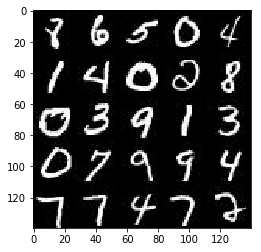

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

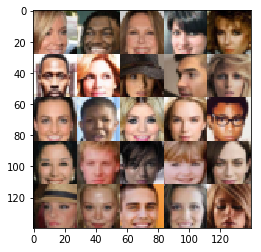

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [24]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [74]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #image shape 28 * 28 * 3
        #这里增加了Xavier的优化
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer= tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        #shape 14 * 14 * 64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer= tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2)#, training = True 这个暂时没加
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)#增加了dropout层
        #shape 7 * 7 * 128
        
        flat = tf.reshape(x2, (-1,7*7*128))
        logits = tf.layers.dense(flat, 1)
        outs = tf.sigmoid(logits)
        
        
    return outs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [75]:
def generator(z, out_channel_dim,is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse = not is_train):#注意这里对reuse的处理
        #注意和最后对比，这里对模型进行了加深
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #shape 7 * 7 * 512  
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=5, strides=2, padding='same', kernel_initializer= tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha  * x2, x2)
        #shape 14 * 14 * 256
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size=5, strides=2, padding='same', kernel_initializer= tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #shape 28 * 28 * 128
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size=5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # shape 28 * 28 * 3
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [69]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)#注意这里要吧reuse设置回来True

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))#增加了smooth处理
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake


    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [70]:
def train(epoch_count, batch_size, z_dim, learning_rate1, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    _, image_width, image_height, image_channels = data_shape
#     tf.reset_default_graph()
    
    input_real, input_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images*2,  input_z: batch_z, learning_rate: learning_rate1})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images*2,  input_z: batch_z, learning_rate: learning_rate1})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images*2})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 36, input_z, image_channels, data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 0.7176
Epoch 1/2... Discriminator Loss: 0.7688... Generator Loss: 1.2484
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.6760
Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 1.0101
Epoch 1/2... Discriminator Loss: 1.6914... Generator Loss: 0.6241
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.8854
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 1.0390
Epoch 1/2... Discriminator Loss: 1.6689... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.8997
Epoch 1/2... Discriminator Loss: 1.7500... Generator Loss: 0.4863


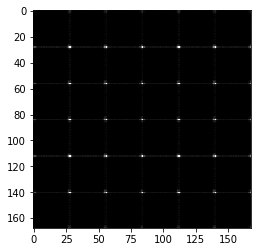

Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 0.8890
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 1.1691
Epoch 1/2... Discriminator Loss: 1.6563... Generator Loss: 0.5700
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.7765
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.7891
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 0.7944


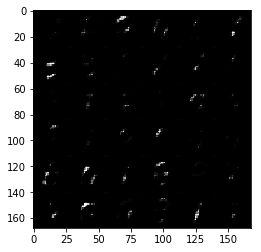

Epoch 1/2... Discriminator Loss: 1.4024... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 0.7956
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 0.7451
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.7718
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.4383... Generator Loss: 0.7557
Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 0.7449


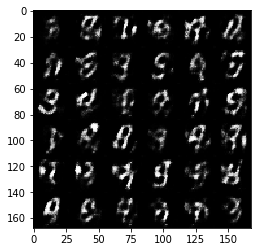

Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 0.7282
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.7452
Epoch 1/2... Discriminator Loss: 1.4298... Generator Loss: 0.7504
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.7623


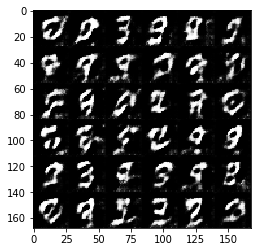

Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.7739
Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.7676
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.7944
Epoch 1/2... Discriminator Loss: 1.3801... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.7668


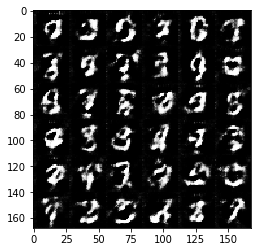

Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.3713... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.7944
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.7893
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7780
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 0.7860


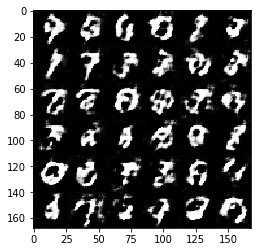

Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.8033
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.3892... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 1.3628... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.9018
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.8575
Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.8093


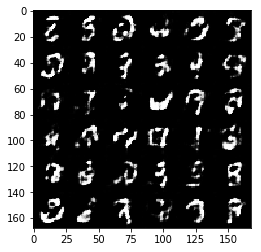

Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 0.7695
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.8147


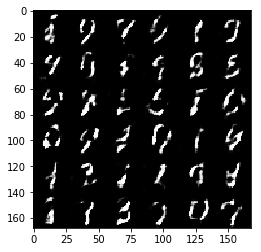

Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.8071
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.3463... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.8540
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.7554


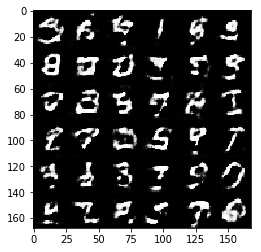

Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 0.7498
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 0.8100
Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 0.8486
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.8486
Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.8604


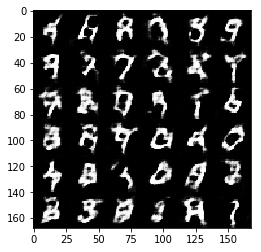

Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 1.4130... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.7387
Epoch 2/2... Discriminator Loss: 1.3368... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 1.4143... Generator Loss: 0.7220
Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.8577
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.8780
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.7473


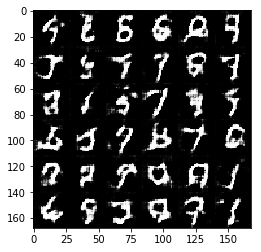

Epoch 2/2... Discriminator Loss: 1.4087... Generator Loss: 0.7066
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.7228
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 0.7810
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.7617
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.8234
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.8199


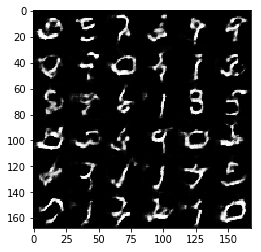

Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 0.8366
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.8700
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.7895
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.8265


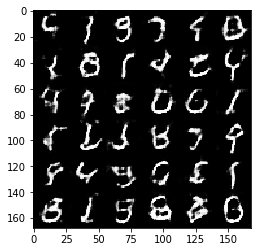

Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.9121
Epoch 2/2... Discriminator Loss: 1.4150... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 0.7355
Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.7263
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.8004


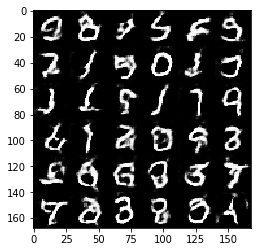

Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.8787
Epoch 2/2... Discriminator Loss: 1.3673... Generator Loss: 0.8313
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 0.7640
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 1.3895... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.3878... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 0.7925


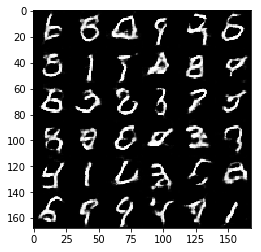

Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.7326
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.7225
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.8962
Epoch 2/2... Discriminator Loss: 1.3555... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.7846
Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.8699
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.7723
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.7365
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7453


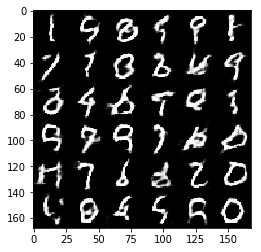

Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.8346
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.7502
Epoch 2/2... Discriminator Loss: 1.3731... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.7257
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.7349


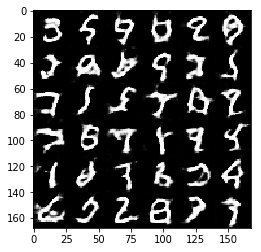

Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.9264
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.7534
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.9274
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.7469
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 1.4193... Generator Loss: 0.9218
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.7477
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.8740
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.7700


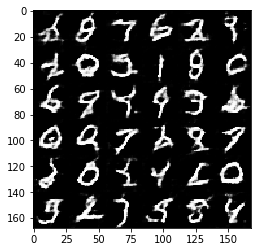

Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 1.4095... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.9621
Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.7452


In [77]:
batch_size = 64
z_dim = 100
learning_rate1 = 0.0002
beta1 = 0.5
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate1, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 2.0466
Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 1.7783
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.2033


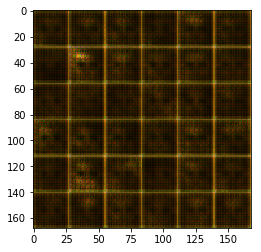

Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.6043
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.9664
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 1.6615... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6186


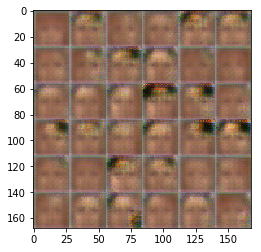

Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7779


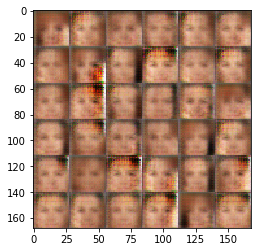

Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.6017... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7482


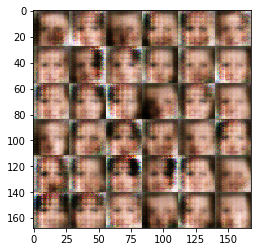

Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7858


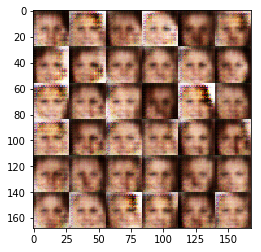

Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.8222


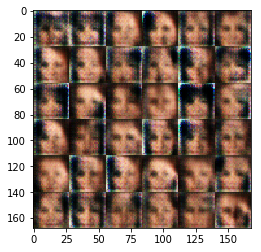

Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7977


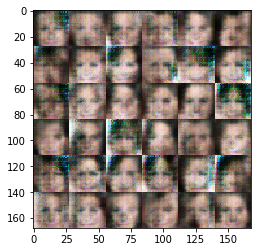

Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7456


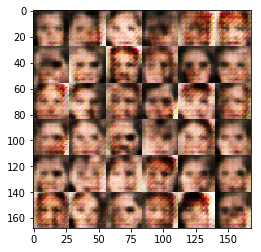

Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7676


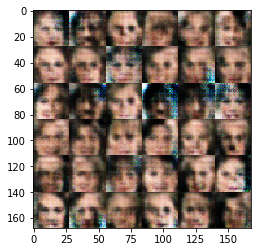

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7862


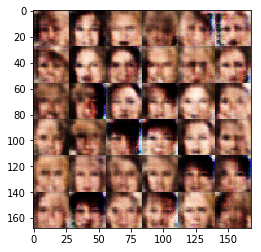

Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7881


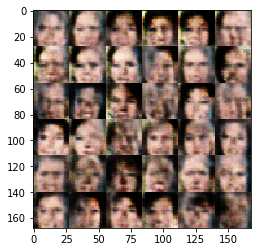

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.9656


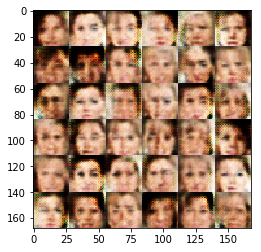

Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7510


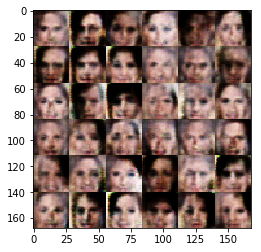

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8237


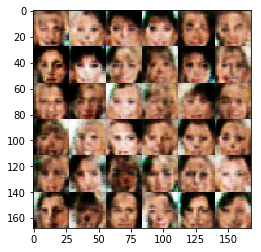

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7770


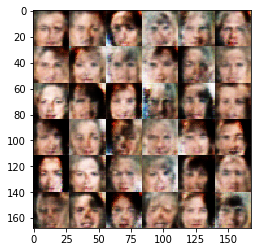

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7570


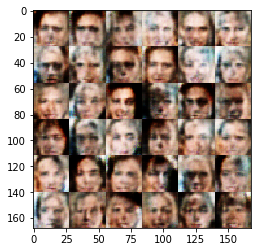

Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8279


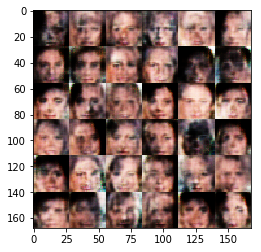

Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.0008


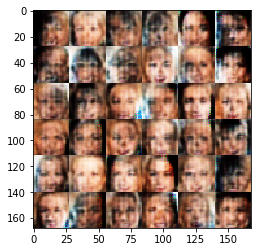

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7952


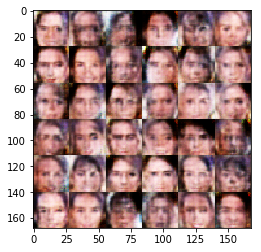

Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8001


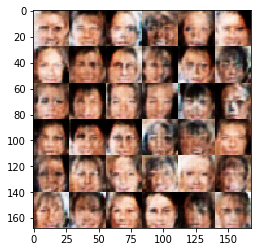

Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8196


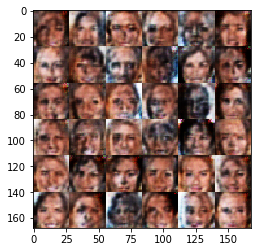

Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.8373


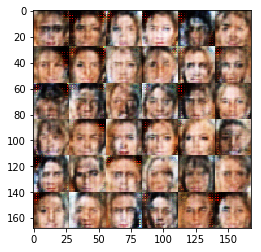

Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7195


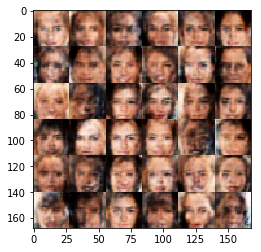

Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7771


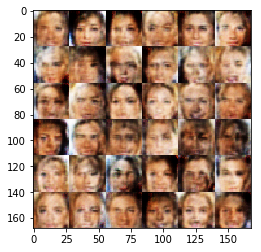

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.8228


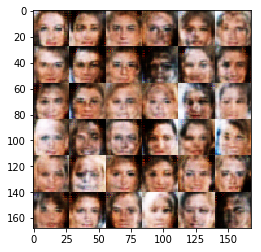

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7593


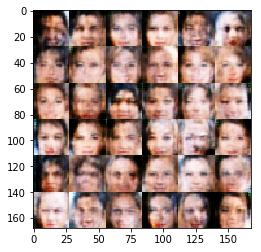

Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.8877


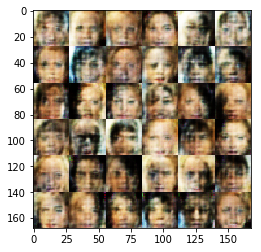

Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8426


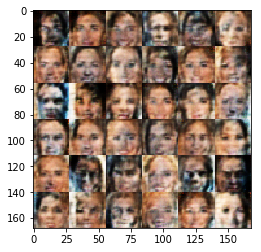

Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7679


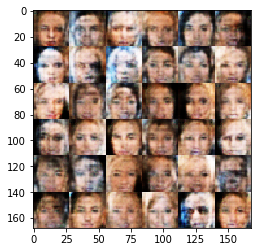

Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.8846


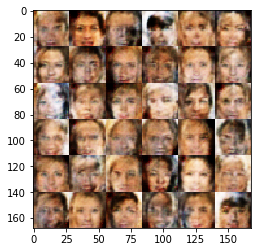

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8925


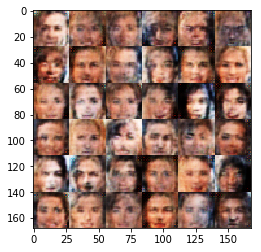

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7394


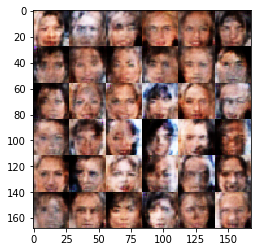

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8913


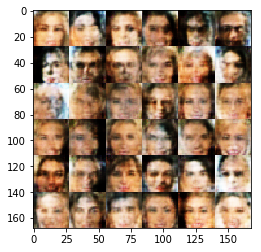

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7438


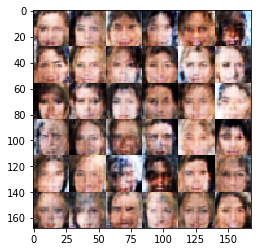

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8306


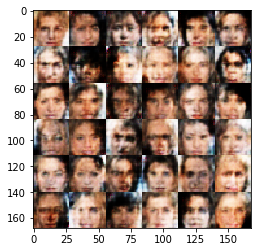

Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7759


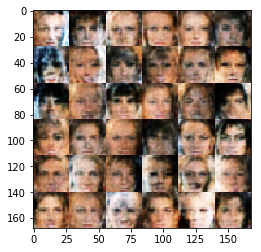

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7971


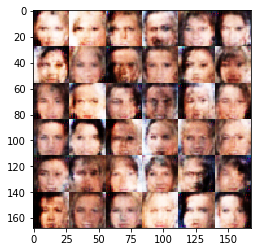

Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7732


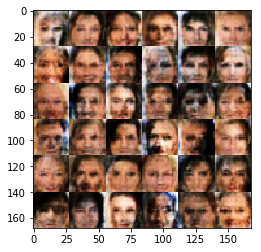

Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7676


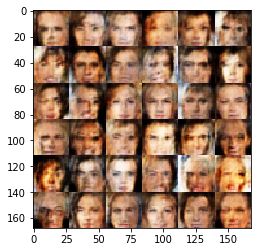

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7611


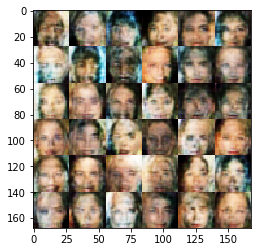

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9448


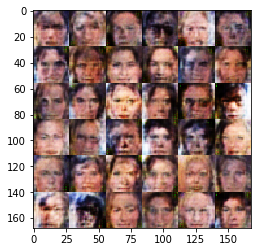

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8196


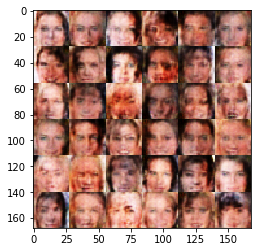

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7998


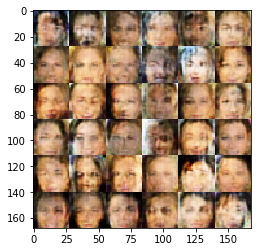

Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7492


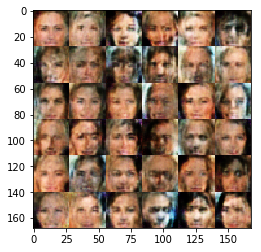

Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7985


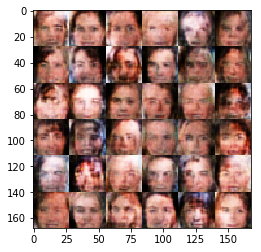

Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7844


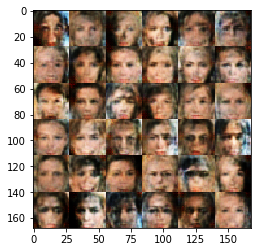

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7578


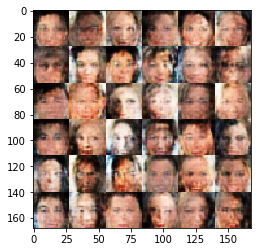

Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8141


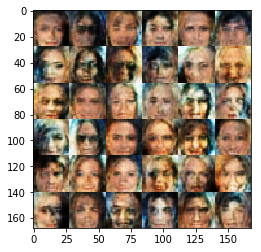

Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7808


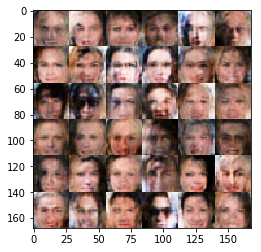

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8079


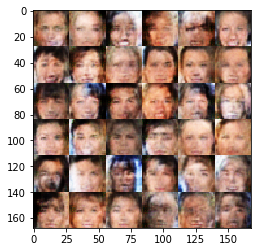

Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8426


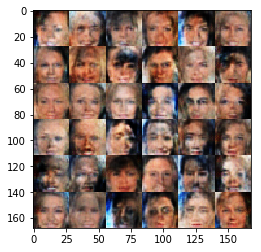

Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7846


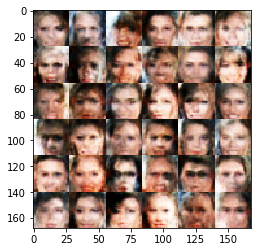

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8137


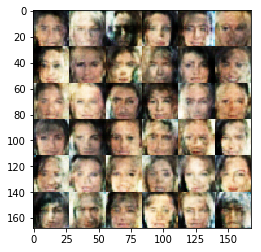

Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7815


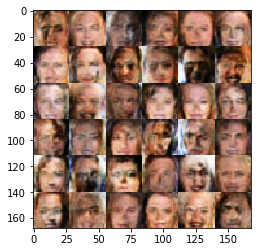

Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8058


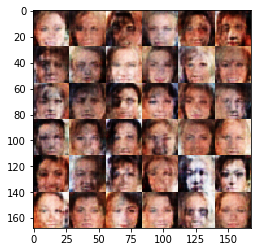

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7837


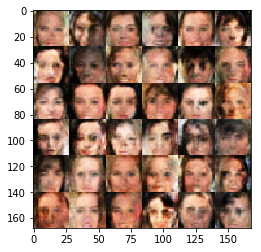

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8135


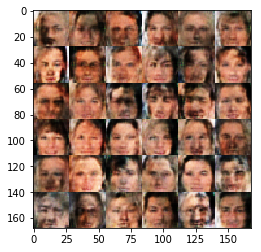

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8087


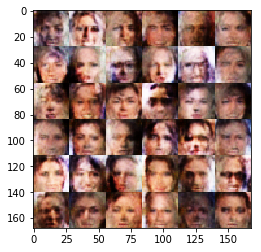

Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.9712


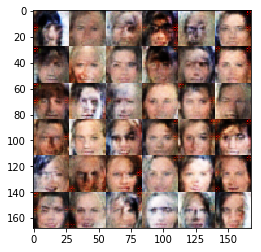

Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7993


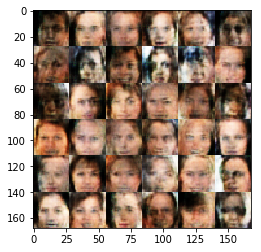

Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8215


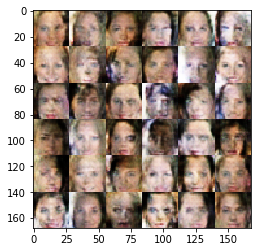

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8085


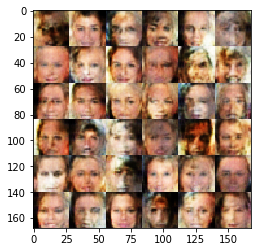

Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8924


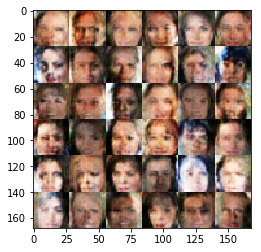

Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8390


In [78]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。

# 我的问题：



1.感觉最后生成的图片并不是特别清晰，是因为epoch不够吗（因为这块项目不让修改），还是因为model架构和超参数的的问题（我对超参数进行了调整，效果变化不明显）？  对模型进行了更改。

2.关于超参数部分，对于z_dim我们应该怎么选取，这块我没特别好的参考，用了之前练习里面的100.但是这块的选择依据是什么？还有beta1的选择，我记得Adam论文里推荐的是0.9，我们这里为什么要用0.5，（我自己调整成0.9后测试了一下，模型确实不学习了，但是还是想知道为什么选择的0.5，是因为在GAN里面的Adam都要选择0.5吗？）

3.还有一个命名冲突的问题，一开始，我在model_input方法里面对学习速率的占位符的取名为learning_rate 在后面的train方法里给要feed进入占位符的学习速率变量也取名和前面的占位符相同也为learning_rate然后在执行的时候就报错了。结果改了feed进入的变量名为learning_rate1就正常了。这两个是不能取相同的名字吗？ 名字最好不要混淆

4.关于generator方法里的tf.layers.conv2d_transpose的生成维度问题。我知道在tf.layers.conv2d 当pa ding=‘same'的时候，输出的空间维度为ceil(float(H_in)/float(s)).  但是如果在本项目中我希望 tf.layers.conv2d_transpose 的输出层宽、高为7 那我应该怎么设置输入层能，这里不是特别理解，以至于我现在的网络架构层数感觉不够。

5.最后一个问题，在train方法里之前练习里加入了tf.reset_default_graph()这样一句，而在本项目没有加，这句的意义何在？为什么要重置默认计算图？


## 之前的生成器的写法：


def generator(z, out_channel_dim,is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator',reuse = not is_train):#注意这里对reuse的处理
        x1 = tf.layers.dense(z, 7*7*128)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #shape 7 * 7 * 128  
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha  * x2, x2)
        #shape 14 * 14 * 64
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        #shape 28 * 28 * 3
        out = tf.tanh(logits)
        
    return out